# Importing and reading the data!

We first start by importing all the libraries

In [1]:
# do the imports
import pickle
from rdkit import Chem
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
from IPython.display import SVG, display
import cairosvg
import math
import numpy as np
import requests
import tqdm

import sys
import os
# add parent directory to path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from SmallMol_Mod_Site_Localization import Compound_n as Compound
from SmallMol_Mod_Site_Localization import ModificationSiteLocator as modSite
from SmallMol_Mod_Site_Localization import utils_n as utils
from SmallMol_Mod_Site_Localization import handle_network as handle_network
from SmallMol_Mod_Site_Localization import visualizer
from SmallMol_Mod_Site_Localization import calculate_scores_n as calculate_scores
from SmallMol_Mod_Site_Localization import alignment_n as alignment

import figures_handler as dh

Then, we load the libraries and the experiments

In [2]:
# get the project root
dir_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(dir_path, os.pardir))

experiment_directory = os.path.join(project_root, 'experiments_settings', "experiments_meta_helpers.csv")
data_folder, results_directory, matches_directory, libraries, library_names = dh.get_basic_data(project_root)

display(libraries[['Library', 'short_name']])

,Library,short_name
0,BERKELEY-LAB,BERKELEY-LAB
1,GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE,GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE


In [3]:
cols_compare = ["id_known", "id_unknown"]
cols_val = "average_dist_normalized"
cols_meta = ['shifted', 'matched', 'weight', 'delta', 'peaks', 'num_helpers']
target_methods = ['none', 'helpers', 'oracle', 'cfmid', 'multiple_random_choice', 'multiple_random_distribution']
target_names = {'none': "MF-N",
            'helpers': "MF-R",
            'oracle': "MF-O",
            'cfmid': "CFM-ID",
            'multiple_random_choice': "RC",
            'multiple_random_distribution': "RD"}
    

In [4]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 25}
font_labels = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 30}

In [5]:
experiment_directory

'/home/user/Substructure_Assignment/my_implementation/ModiFinder_Analysis/experiments_settings/experiments_meta_helpers.csv'

In [6]:
methods_data = dh.combine_merged_libraries(library_names, experiment_directory, results_directory)
print("methods are: ", list(methods_data.keys()))
pairs_with_at_least_one_annotated_shift = methods_data["oracle"][methods_data["oracle"]["shifted_annotated_ambiguity"] > 0]
# select only id columns
pairs_with_at_least_one_annotated_shift = pairs_with_at_least_one_annotated_shift[["id_known", "id_unknown"]]


pairs_with_at_least_one_helper = methods_data["oracle"][methods_data["oracle"]["num_helpers"] > 0]
# select only id columns
pairs_with_at_least_one_helper = pairs_with_at_least_one_helper[cols_compare]
print(len(methods_data['oracle']), len(pairs_with_at_least_one_annotated_shift), len(pairs_with_at_least_one_helper))

our_predictions = methods_data['helpers'].merge(pairs_with_at_least_one_annotated_shift, on=cols_compare, how='inner')

methods are:  ['none', 'sirius', 'msbuddy', 'oracle', 'helpers', 'oracle_nohelper', 'cfmid', 'multiple_random_choice', 'multiple_random_distribution']
1500 917 1039


# Bad Examples

The following contains only one shifted peak and one unshifted peak, intrestingly, unshifted peak contains the modification site as well. so when the subtraction happens, it removes the modification site too!

https://modifinder.gnps2.org/?USI1=mzspec:GNPS:GNPS-MSMLS:accession:CCMSLIB00005464298&USI2=mzspec:GNPS:GNPS-MSMLS:accession:CCMSLIB00005464153&SMILES1=N[C@@H](CC1=CNC=N1)C(O)=O&SMILES2=CN1C=NC(C[C@H](N)C(O)=O)=C1


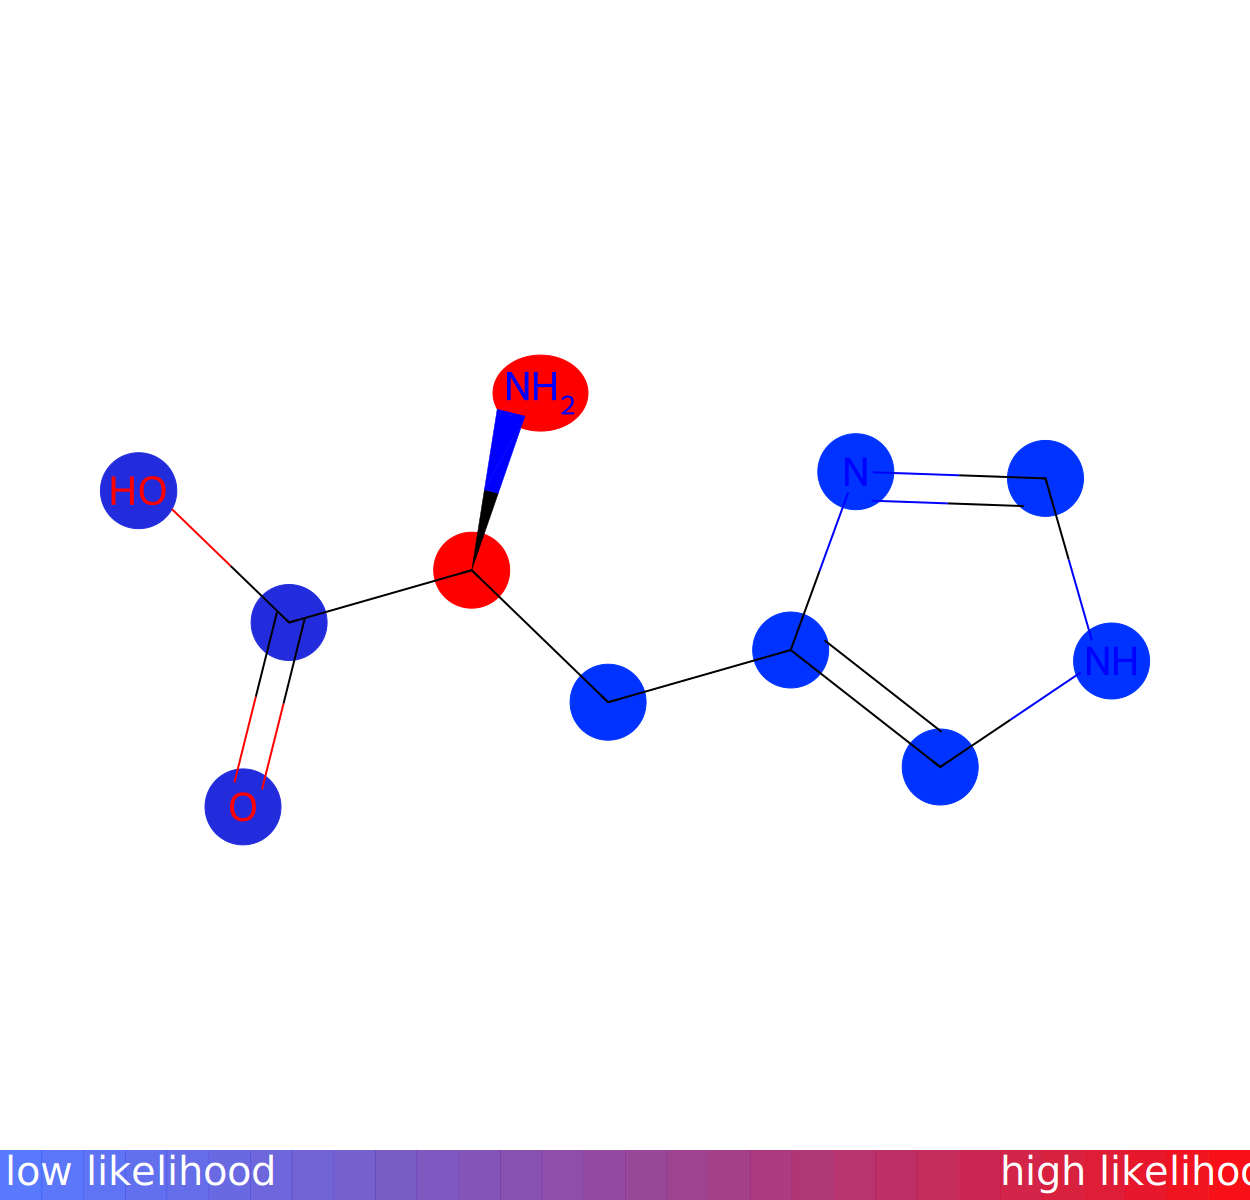

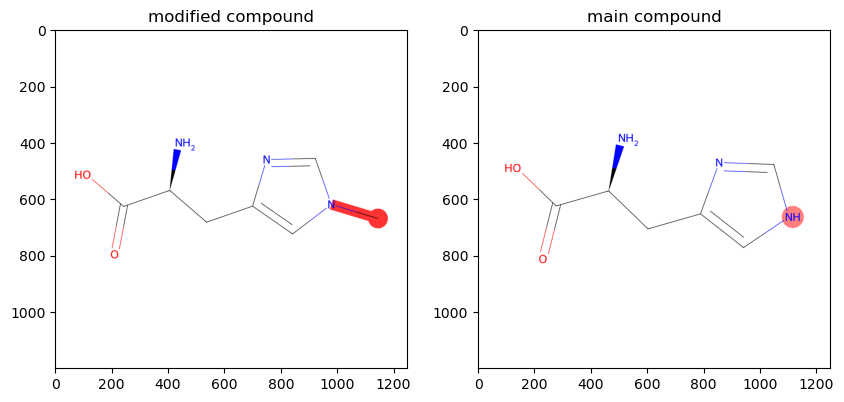

In [7]:
example1 = {'smaller_id':'CCMSLIB00005464298', 'bigger_id':'CCMSLIB00005464153'}

smaller_id = example1["smaller_id"]
bigger_id = example1["bigger_id"]
args = {'fragmentation_depth':2, "mz_tolerance": 0.1, "ppm": 40, "filter_peaks_method": "intensity", "filter_peaks_variable": 0.01}
mod_site_obj = modSite.ModificationSiteLocator(smaller_id, bigger_id, args = args)
true_site = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)[0]
modifLoc = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)
link = handle_network.create_link_from_accession(smaller_id, bigger_id)
print(link)
dh.draw_molecules(mod_site_obj.main_compound, mod_site_obj.modified_compound, modifLoc)
prediction_before = mod_site_obj.generate_probabilities()
# prediction_before = prediction_before/np.max(prediction_before)
svg = visualizer.highlightScores(mod_site_obj.main_compound.structure, prediction_before, False, True, 1)
SVG(svg)

For the next example, Due to the simmatry of the OH's and only one shifted peak, it cannot correctly guess the location

https://modifinder.gnps2.org/?USI1=mzspec:GNPS:GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE:accession:CCMSLIB00000847156&USI2=mzspec:GNPS:GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE:accession:CCMSLIB00000847119&SMILES1=OC1=CC=C(C=C1)C2OC3=C(C(=O)C2C4C(OC5=C(C4=O)C(O)=CC(O)=C5)C6=CC=C(O)C=C6)C(O)=CC(O)=C3&SMILES2=COC1=CC=C(C=C1)C2OC3=CC(O)=CC(O)=C3C(=O)C2C4C(OC5=CC(O)=CC(O)=C5C4=O)C6=CC=C(O)C=C6


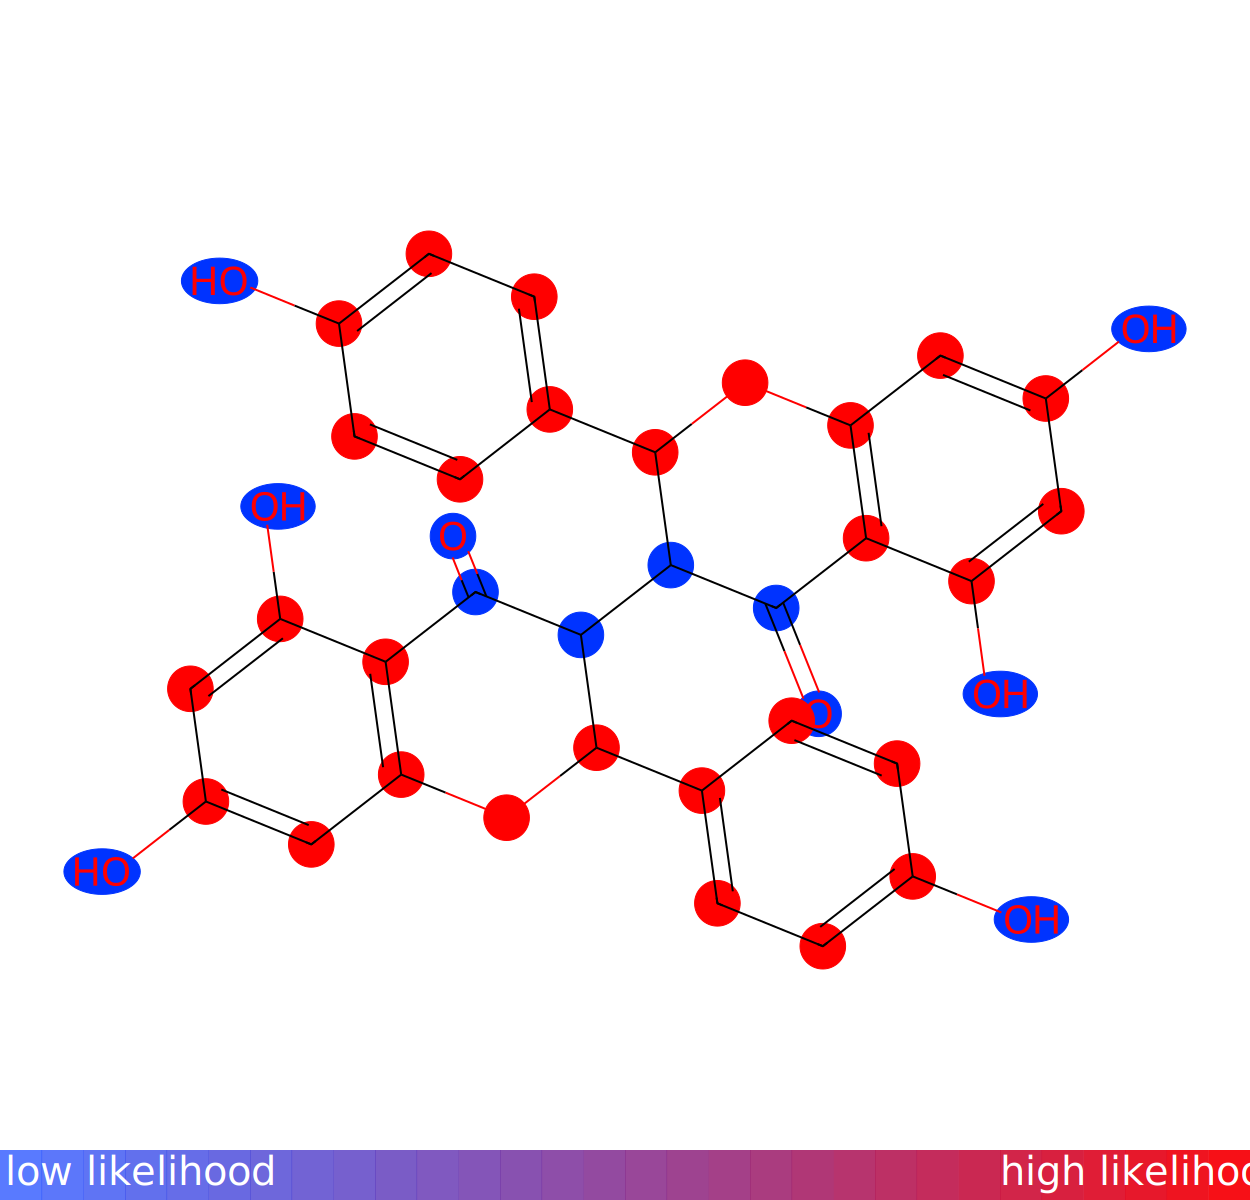

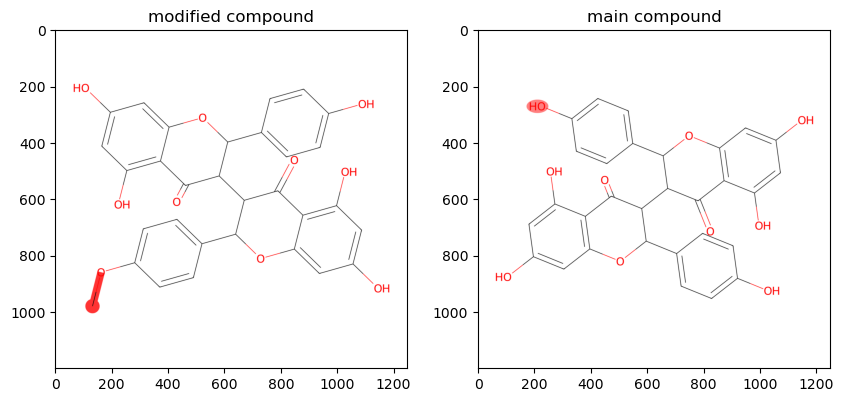

In [8]:
example2 = {'smaller_id':'CCMSLIB00000847156', 'bigger_id':'CCMSLIB00000847119'}
smaller_id = example2["smaller_id"]
bigger_id = example2["bigger_id"]
args = {'fragmentation_depth':2, "mz_tolerance": 0.1, "ppm": 40, "filter_peaks_method": "intensity", "filter_peaks_variable": 0.01}
mod_site_obj = modSite.ModificationSiteLocator(smaller_id, bigger_id, args = args)
true_site = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)[0]
modifLoc = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)
link = handle_network.create_link_from_accession(smaller_id, bigger_id)
print(link)
dh.draw_molecules(mod_site_obj.main_compound, mod_site_obj.modified_compound, modifLoc)
prediction_before = mod_site_obj.generate_probabilities()
# prediction_before = prediction_before/np.max(prediction_before)
svg = visualizer.highlightScores(mod_site_obj.main_compound.structure, prediction_before, False, True, 1)
SVG(svg)

# Mid Examples

Let's pick an example that the program can predict but is not very confident

https://modifinder.gnps2.org/?USI1=mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00010113829&USI2=mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00010125628&SMILES1=COC(=O)C1=C(N)Oc2c(c(=O)oc3ccccc23)C1c1ccccc1Br&SMILES2=CCOC(=O)C1=C(N)Oc2c(c(=O)oc3ccccc23)C1c1ccccc1Br


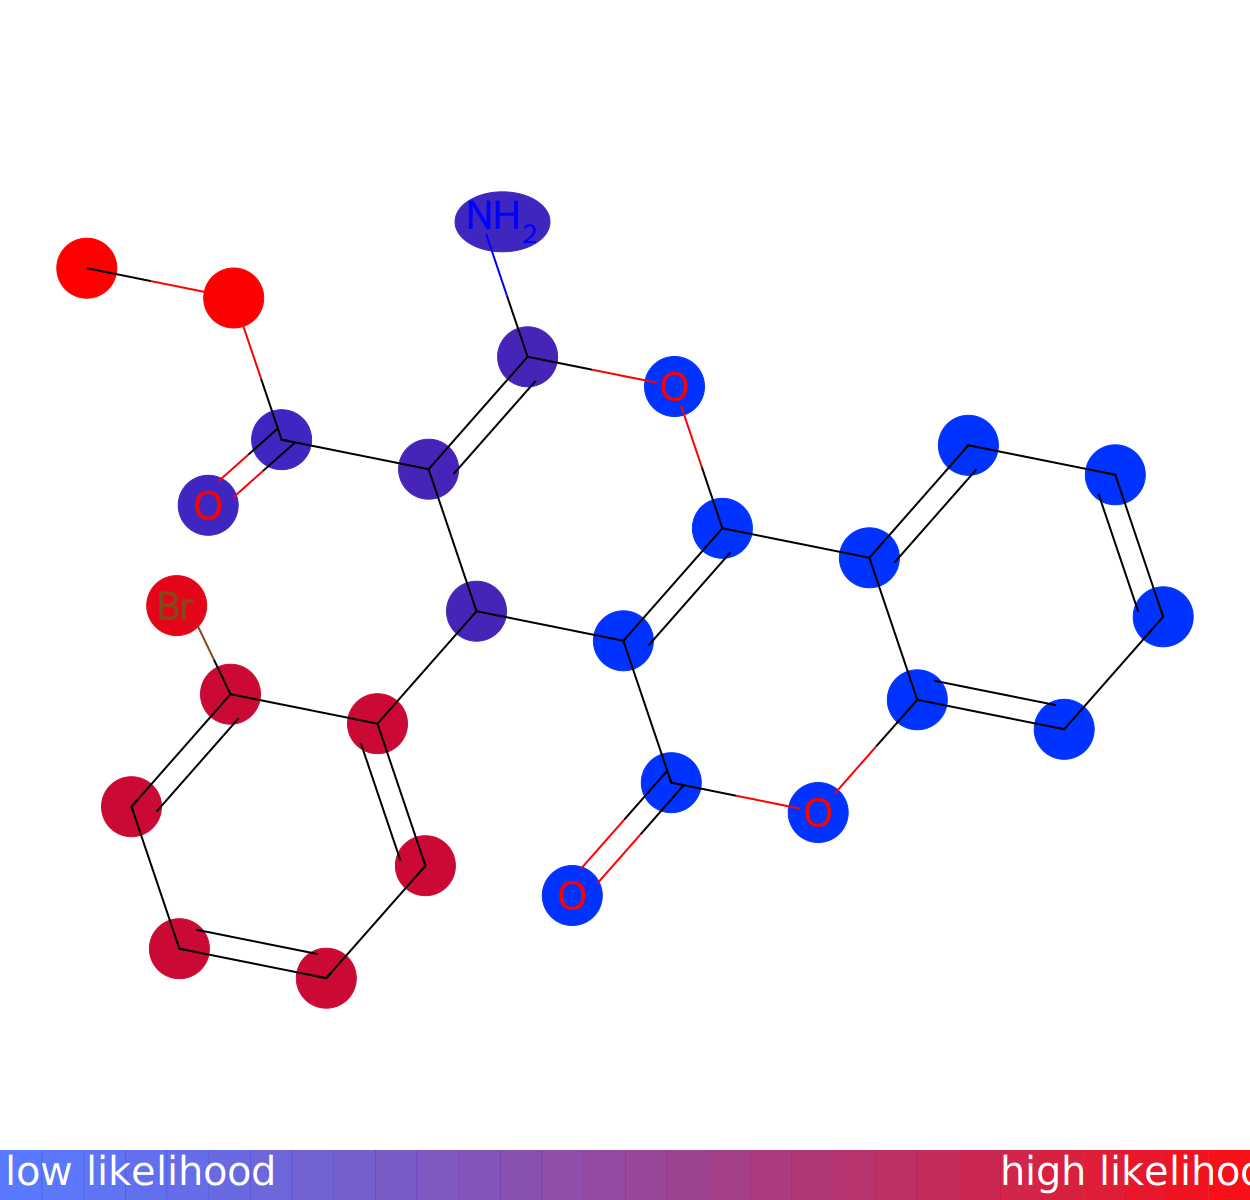

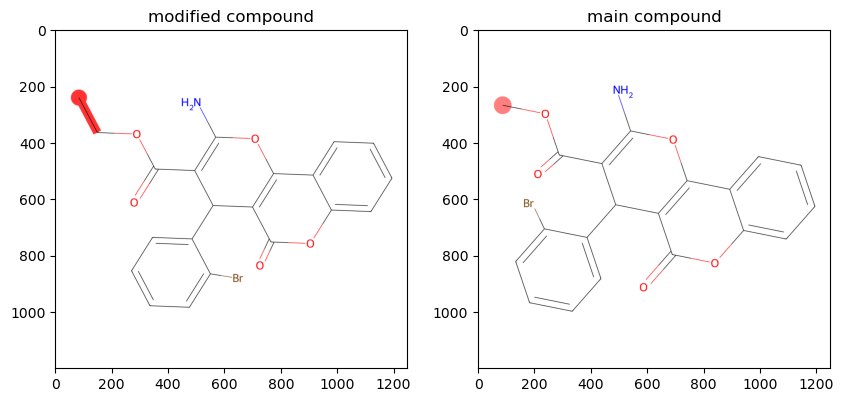

In [11]:
example4 = {'smaller_id':'CCMSLIB00010113829', 'bigger_id':'CCMSLIB00010125628'}
smaller_id = example4["smaller_id"]
bigger_id = example4["bigger_id"]
args = {'fragmentation_depth':2, "mz_tolerance": 0.1, "ppm": 40, "filter_peaks_method": "intensity", "filter_peaks_variable": 0.01}
mod_site_obj = modSite.ModificationSiteLocator(smaller_id, bigger_id, args = args)
true_site = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)[0]
modifLoc = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)
link = handle_network.create_link_from_accession(smaller_id, bigger_id)
print(link)
dh.draw_molecules(mod_site_obj.main_compound, mod_site_obj.modified_compound, modifLoc)
prediction_before = mod_site_obj.generate_probabilities()
# prediction_before = prediction_before/np.max(prediction_before)
svg = visualizer.highlightScores(mod_site_obj.main_compound.structure, prediction_before, False, True, 1)
SVG(svg)

https://modifinder.gnps2.org/?USI1=mzspec:GNPS:GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE:accession:CCMSLIB00000848585&USI2=mzspec:GNPS:GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE:accession:CCMSLIB00000852883&SMILES1=COC(=O)C1=COC(OC2OC(CO)C(O)C(O)C2O)C(C=C)C1CC=O&SMILES2=COC(=O)C/1=C/OC(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)C(C=C)C1CC(O)=O


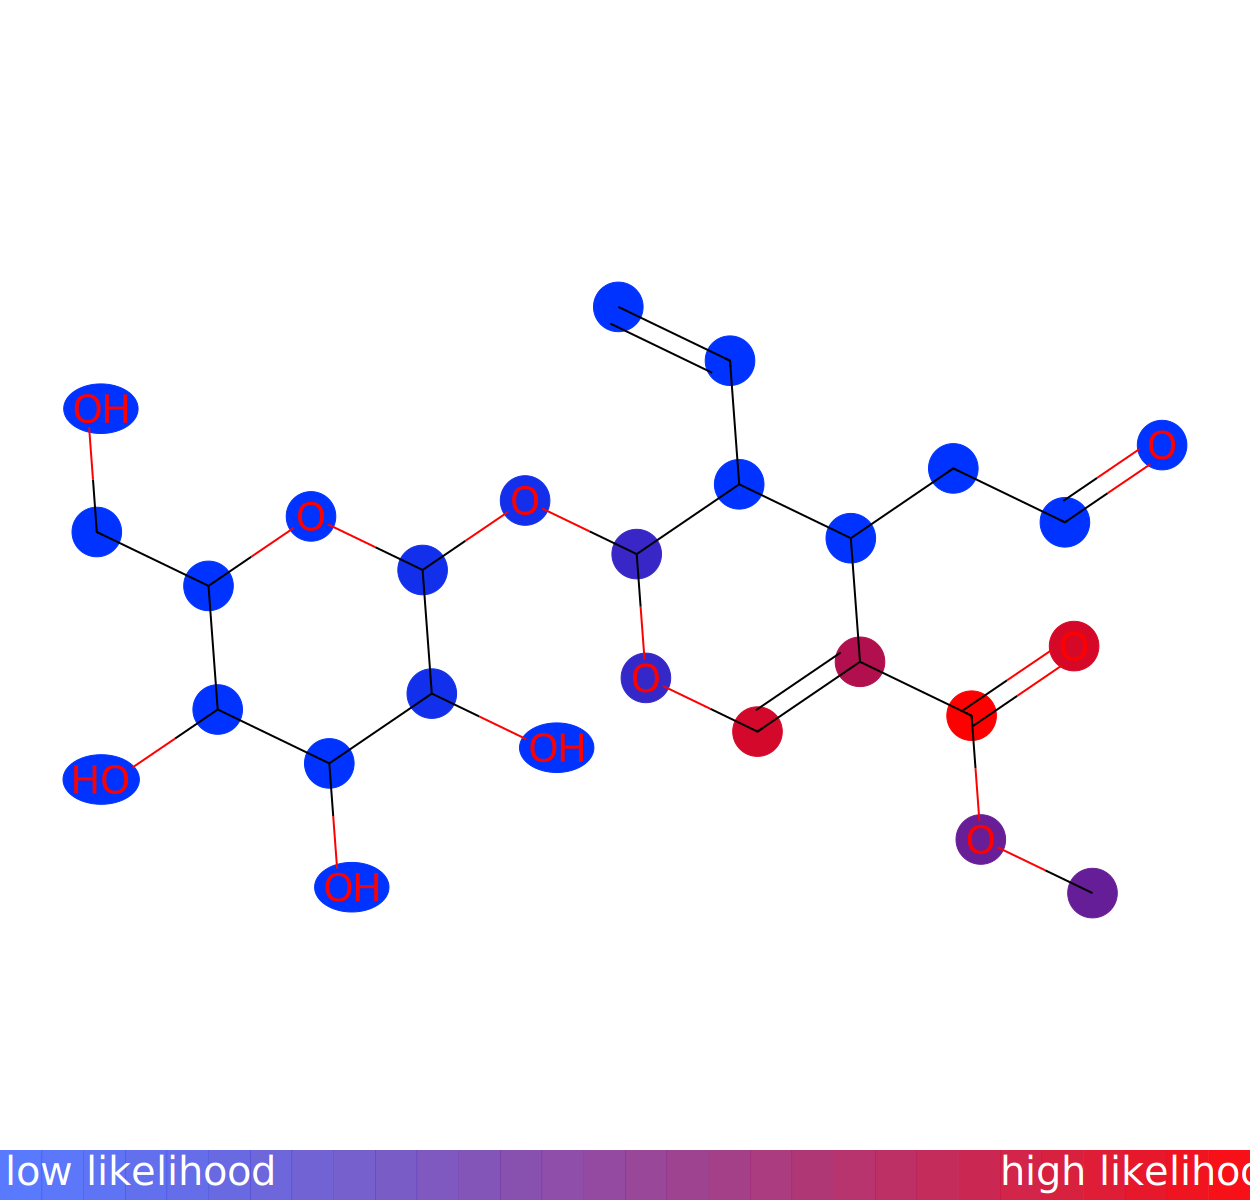

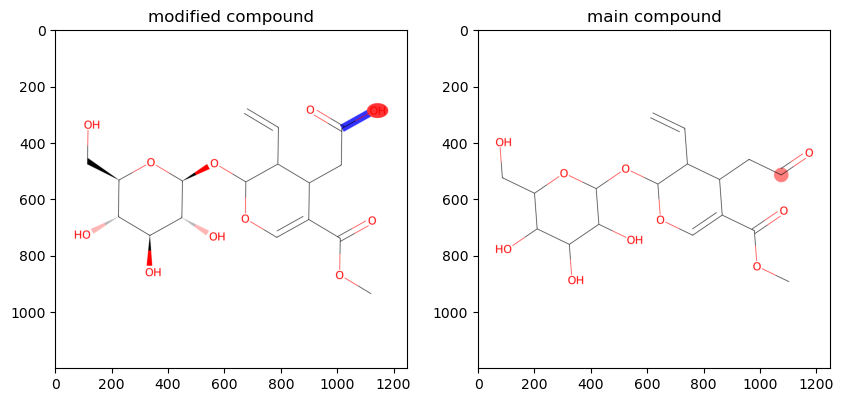

In [12]:
example5 = {'smaller_id':'CCMSLIB00000848585', 'bigger_id':'CCMSLIB00000852883'}
smaller_id = example5["smaller_id"]
bigger_id = example5["bigger_id"]
args = {'fragmentation_depth':2, "mz_tolerance": 0.1, "ppm": 40, "filter_peaks_method": "intensity", "filter_peaks_variable": 0.01}
mod_site_obj = modSite.ModificationSiteLocator(smaller_id, bigger_id, args = args)
true_site = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)[0]
modifLoc = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)
link = handle_network.create_link_from_accession(smaller_id, bigger_id)
print(link)
dh.draw_molecules(mod_site_obj.main_compound, mod_site_obj.modified_compound, modifLoc)
prediction_before = mod_site_obj.generate_probabilities()
# prediction_before = prediction_before/np.max(prediction_before)
svg = visualizer.highlightScores(mod_site_obj.main_compound.structure, prediction_before, False, True, 1)
SVG(svg)

# good examples

https://modifinder.gnps2.org/?USI1=mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00010118545&USI2=mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00010109956&SMILES1=COc1ccc2[nH]c(C)c(CCN=C(O)c3ccc(OC)c(OC)c3)c2c1&SMILES2=COc1ccc(C(O)=NCCc2c(C)[nH]c3ccc(OCc4ccccc4)cc23)cc1OC


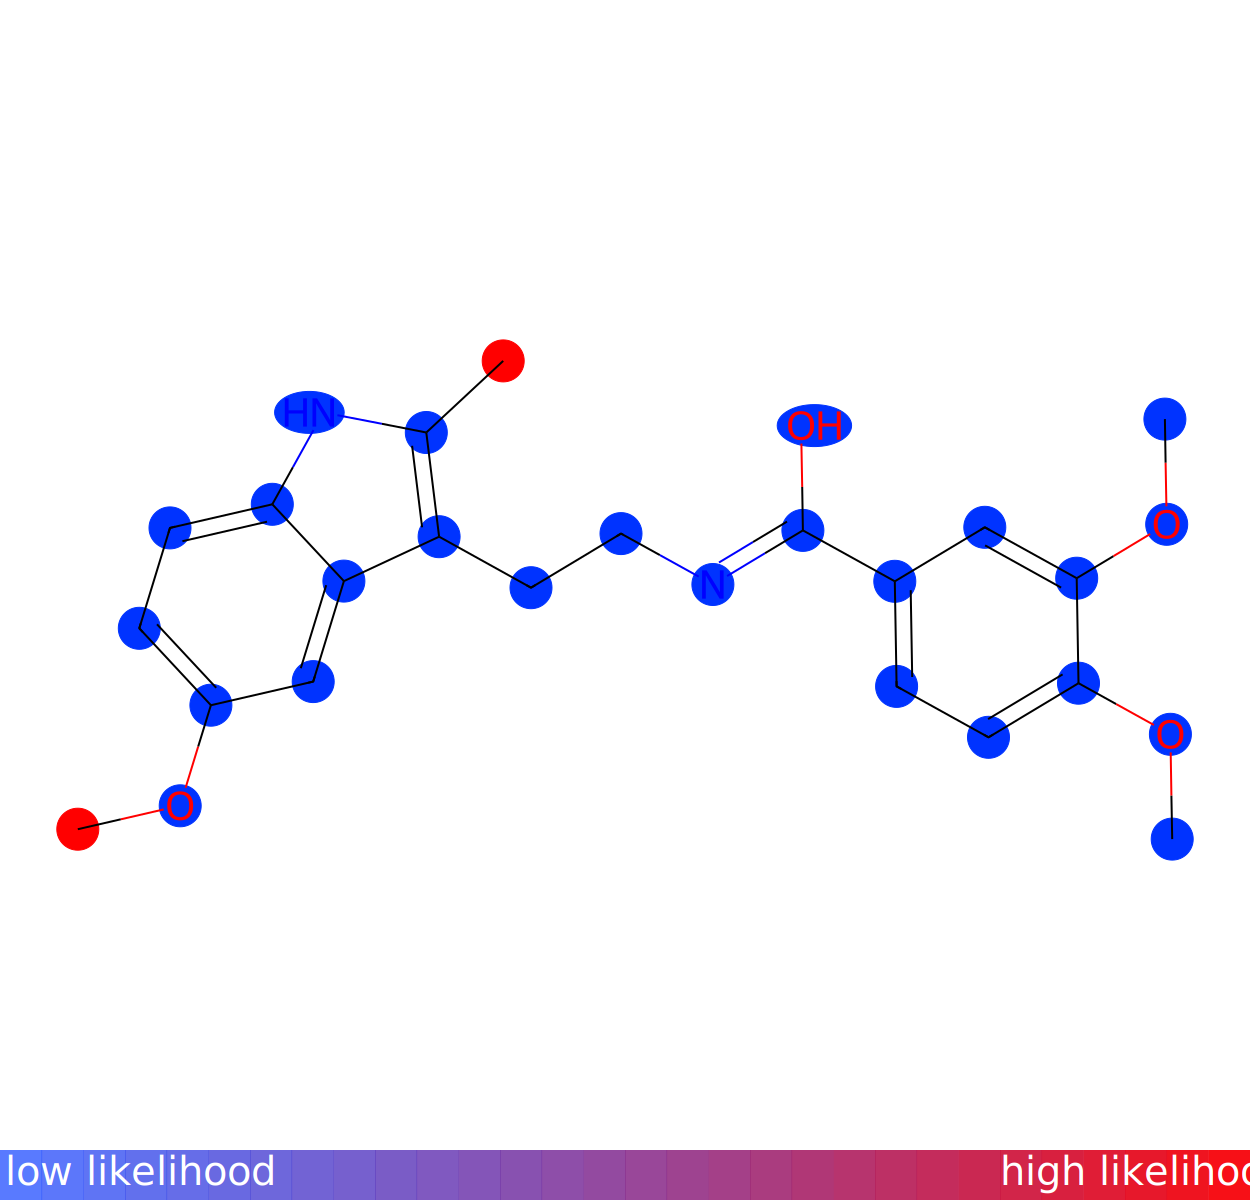

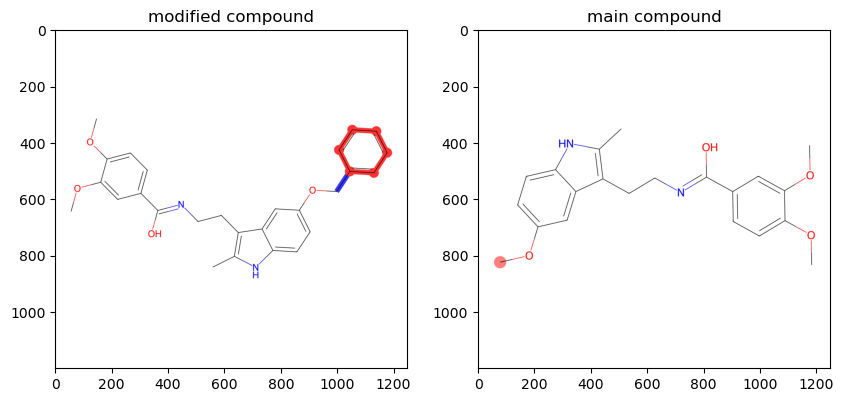

In [15]:
example6 = {'smaller_id':'CCMSLIB00010118545', 'bigger_id':'CCMSLIB00010109956'}
smaller_id = example6["smaller_id"]
bigger_id = example6["bigger_id"]
args = {'fragmentation_depth':2, "mz_tolerance": 0.1, "ppm": 40, "filter_peaks_method": "intensity", "filter_peaks_variable": 0.01}
mod_site_obj = modSite.ModificationSiteLocator(smaller_id, bigger_id, args = args)
true_site = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)[0]
modifLoc = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)
link = handle_network.create_link_from_accession(smaller_id, bigger_id)
print(link)
dh.draw_molecules(mod_site_obj.main_compound, mod_site_obj.modified_compound, modifLoc)
prediction_before = mod_site_obj.generate_probabilities()
# prediction_before = prediction_before/np.max(prediction_before)
svg = visualizer.highlightScores(mod_site_obj.main_compound.structure, prediction_before, False, True, 1)
SVG(svg)

https://modifinder.gnps2.org/?USI1=mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00010118185&USI2=mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00010104042&SMILES1=COc1ccc(CC2NCCc3cc(OC)c(OC)cc32)cc1OC&SMILES2=COc1ccc(CC2c3cc(OC)c(OC)cc3CCN2C)cc1OC
0.9651123912141446


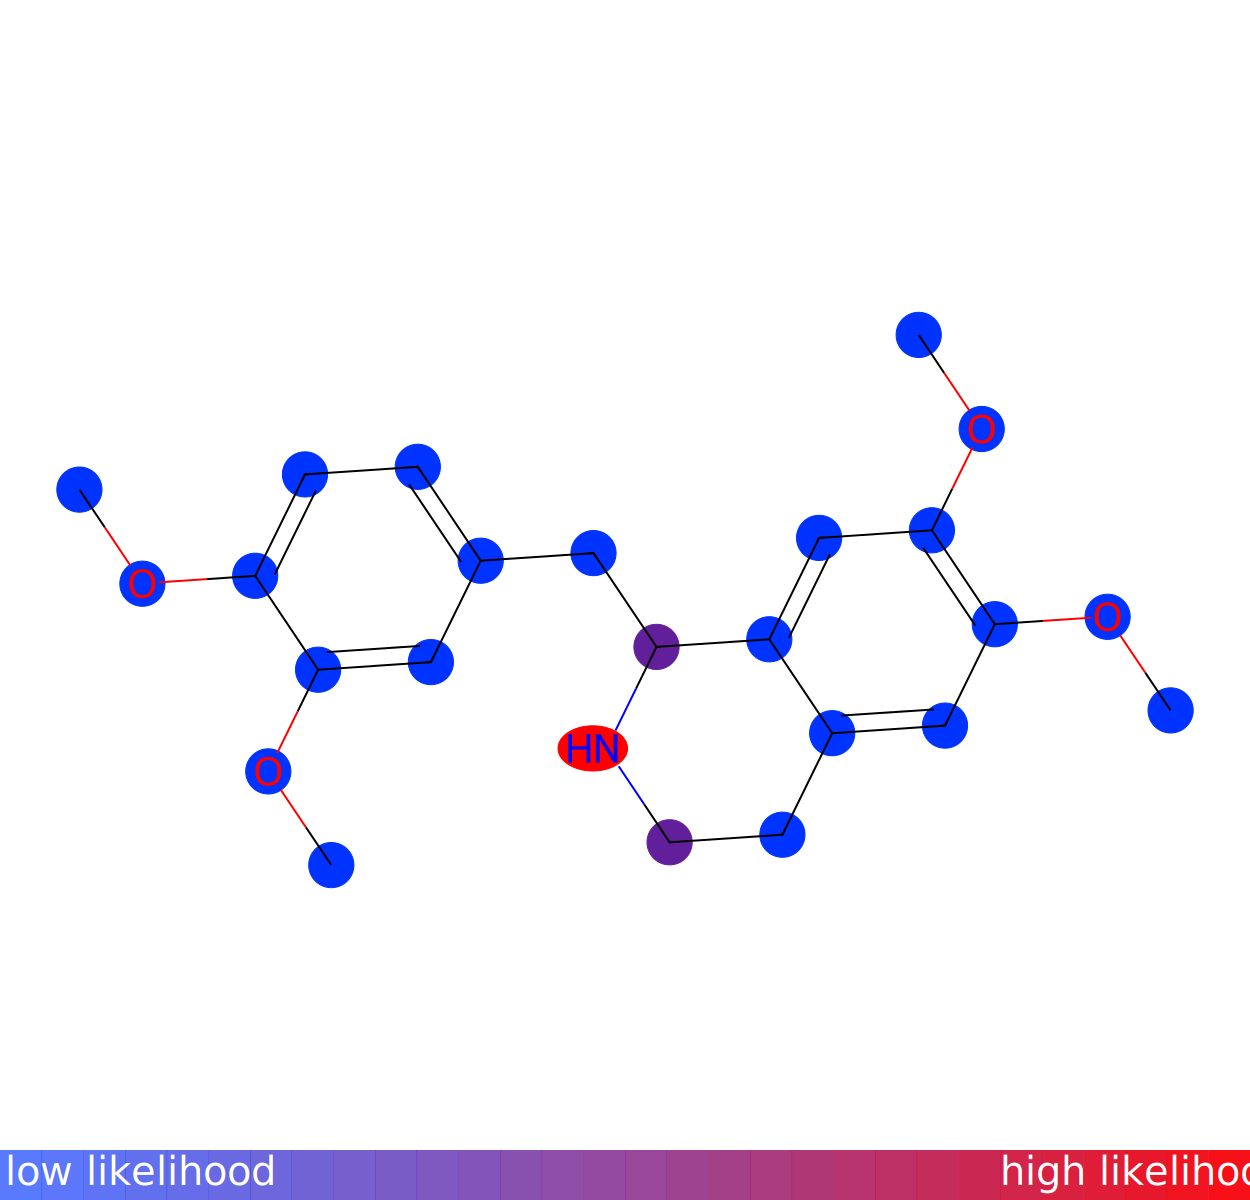

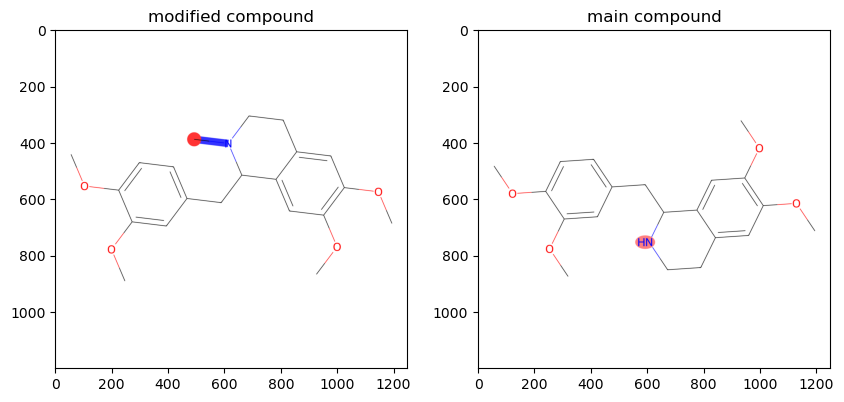

In [16]:
example7 = {'smaller_id':'CCMSLIB00010118185', 'bigger_id':'CCMSLIB00010104042'}
smaller_id = example7["smaller_id"]
bigger_id = example7["bigger_id"]
args = {'fragmentation_depth':2, "mz_tolerance": 0.1, "ppm": 40, "filter_peaks_method": "intensity", "filter_peaks_variable": 0.01}
mod_site_obj = modSite.ModificationSiteLocator(smaller_id, bigger_id, args = args)
true_site = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)[0]
modifLoc = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)

link = handle_network.create_link_from_accession(smaller_id, bigger_id)
print(link)
dh.draw_molecules(mod_site_obj.main_compound, mod_site_obj.modified_compound, modifLoc)
prediction_before = mod_site_obj.generate_probabilities()
print(mod_site_obj.calculate_score(true_site, "average_dist_normalized", prediction_before))
# prediction_before = prediction_before/np.max(prediction_before)
svg = visualizer.highlightScores(mod_site_obj.main_compound.structure, prediction_before, False, True, 1)
SVG(svg)

In [17]:
from io import BytesIO
from PIL import Image
from rdkit import Chem
from rdkit.Chem import Draw
def highlightScores(mol, scores, add_labels = False, shrink_labels = False, label_size = 0.5):
    if min(scores) < 0:
        scores = [x + abs(min(scores)) for x in scores]
    if max(scores) > 0:
        vals = [x/max(scores) for x in scores]
    else:
        vals = [0 for x in scores]
    d2d = Draw.MolDraw2DCairo(1200, 1200)
    colors = dict()
    for i in range(0, mol.GetNumAtoms()):
        # heat map coloring
        if vals[i] == 0:
            colors[i] = (vals[i], 0.2*(1-vals[i]), 1-vals[i], 0.4)
        else:
            colors[i] = (vals[i], 0.2*(1-vals[i]), 1-vals[i], vals[i]*0.3 + 0.65)
    if add_labels:
        d2d.drawOptions().annotationFontScale = label_size
        for atom in mol.GetAtoms():
            lbl = str(round(scores[atom.GetIdx()], 2))
            if shrink_labels:
                if scores[atom.GetIdx()] == 0:
                    lbl = ""
                else:
                    lbl = str(int(round(scores[atom.GetIdx()], 2)*100))
            atom.SetProp('atomNote',lbl)
            # set font size for labels
    d2d.DrawMolecule(mol, highlightAtoms=list(range(mol.GetNumAtoms())), highlightAtomColors=colors, highlightBonds=[])
    d2d.FinishDrawing()
    return d2d.GetDrawingText()
    

https://modifinder.gnps2.org/?USI1=mzspec:GNPS:GNPS-MSMLS:accession:CCMSLIB00005464298&USI2=mzspec:GNPS:GNPS-MSMLS:accession:CCMSLIB00005464153&SMILES1=N[C@@H](CC1=CNC=N1)C(O)=O&SMILES2=CN1C=NC(C[C@H](N)C(O)=O)=C1
https://modifinder.gnps2.org/?USI1=mzspec:GNPS:GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE:accession:CCMSLIB00000847156&USI2=mzspec:GNPS:GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE:accession:CCMSLIB00000847119&SMILES1=OC1=CC=C(C=C1)C2OC3=C(C(=O)C2C4C(OC5=C(C4=O)C(O)=CC(O)=C5)C6=CC=C(O)C=C6)C(O)=CC(O)=C3&SMILES2=COC1=CC=C(C=C1)C2OC3=CC(O)=CC(O)=C3C(=O)C2C4C(OC5=CC(O)=CC(O)=C5C4=O)C6=CC=C(O)C=C6
https://modifinder.gnps2.org/?USI1=mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00010113829&USI2=mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00010125628&SMILES1=COC(=O)C1=C(N)Oc2c(c(=O)oc3ccccc23)C1c1ccccc1Br&SMILES2=CCOC(=O)C1=C(N)Oc2c(c(=O)oc3ccccc23)C1c1ccccc1Br
https://modifinder.gnps2.org/?USI1=mzspec:GNPS:GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE:accession:CCMSLIB00000848

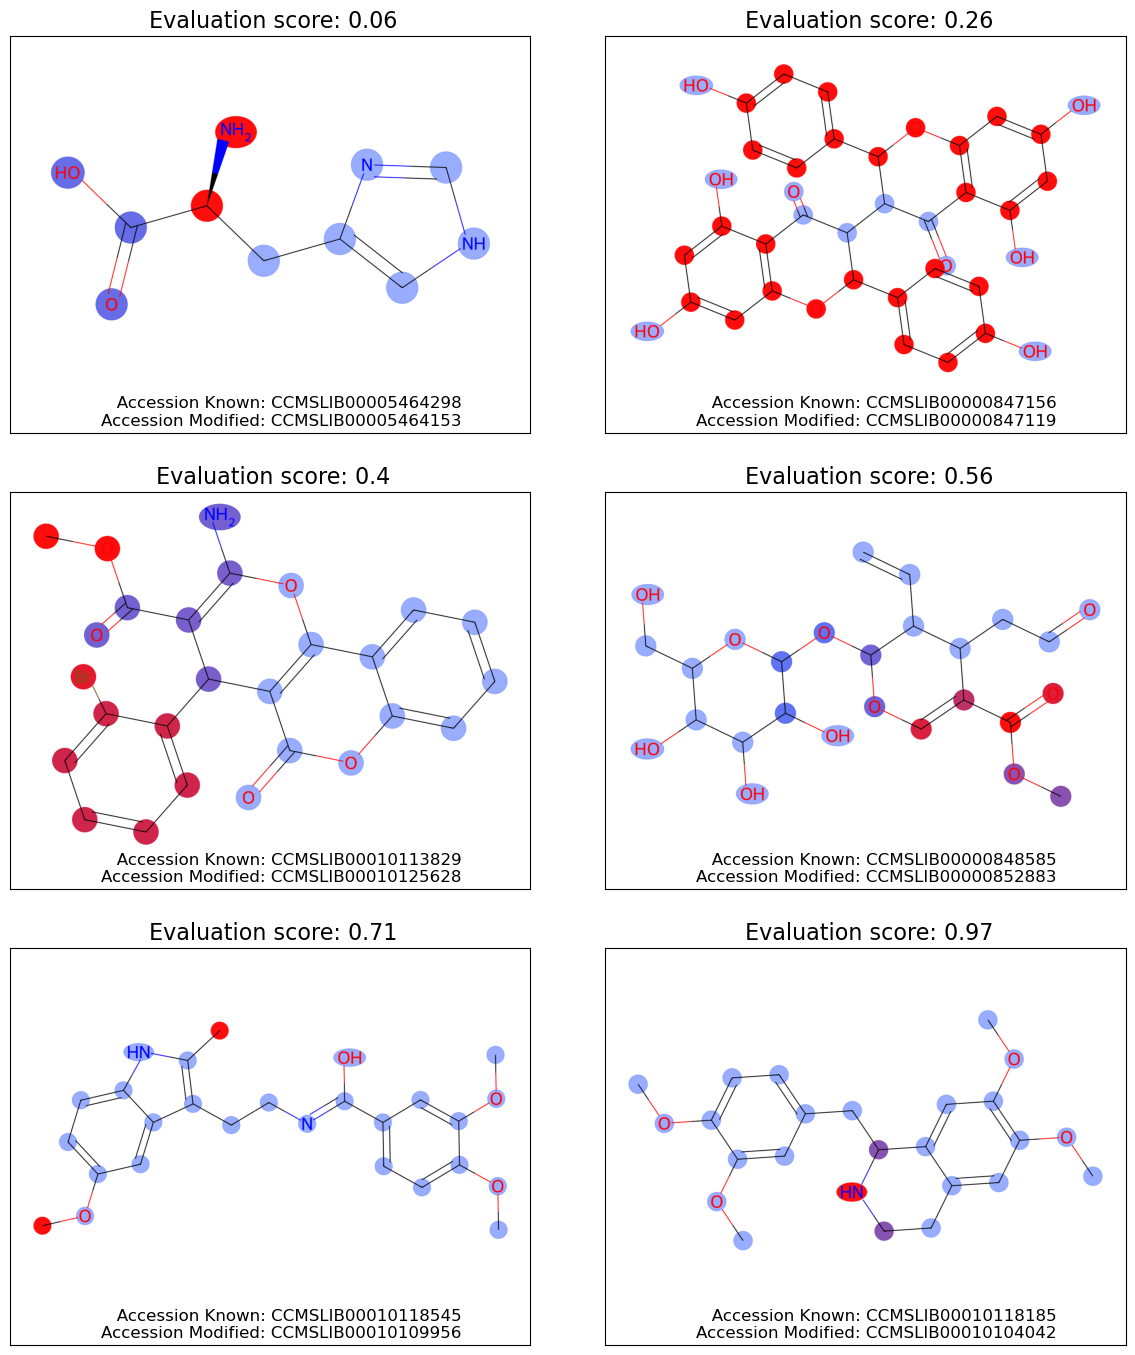

In [18]:
examples = [example1, example2, example4, example5, example6, example7]
fig, ax = plt.subplots(3, 2, figsize=(15, 17))
# remove distance between subplots
fig.subplots_adjust(hspace=0.15, wspace=0.05)

for i, example in enumerate(examples):
    smaller_id = example["smaller_id"]
    bigger_id = example["bigger_id"]
    args = {'fragmentation_depth':2, "mz_tolerance": 0.1, "ppm": 40, "filter_peaks_method": "intensity", "filter_peaks_variable": 0.01}
    mod_site_obj = modSite.ModificationSiteLocator(smaller_id, bigger_id, args = args)
    true_site = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)[0]
    modifLoc = utils.calculateModificationSites(mod_site_obj.modified_compound.structure, mod_site_obj.main_compound.structure, False)
    link = handle_network.create_link_from_accession(smaller_id, bigger_id)
    print(link)
    # dh.draw_molecules(mod_site_obj.main_compound, mod_site_obj.modified_compound, modifLoc)
    prediction_before = mod_site_obj.generate_probabilities()
    score = mod_site_obj.calculate_score(true_site, "average_dist_normalized", prediction_before)
    score = round(score, 2)
    # prediction_before = prediction_before/np.max(prediction_before)
    png = highlightScores(mod_site_obj.main_compound.structure, prediction_before, False, True, 1)
    png = mpimg.imread(BytesIO(png))
    # # save svg
    # with open('temp.svg', 'w') as f:
    #     f.write(svg)
    # # convert svg to png and keep alpha channel
    # svg_to_png = cairosvg.svg2png(bytestring=svg)
    # # save the png to a file
    # with open('temp.png', 'wb') as f:
    #     f.write(svg_to_png)
    # # png = mpimg.imread(io.BytesIO(svg_to_png), format='PNG')
    # png = svg_to_png_with_transparency('temp.svg')
    # # remove the last 180px from the png
    png = png[180:png.shape[0]-180]
    # # add 50 pixels of white space at the bottom
    png = np.concatenate((png, np.ones((75, png.shape[1], 3))), axis=0)
    ax[i//2, i%2].imshow(png)
    # # remove ticks and make the border gray
    ax[i//2, i%2].set_xticks([])
    ax[i//2, i%2].set_yticks([])
    # ax[i//2, i%2].spines['top'].set_color('gray')

    # # put title inside the image at the top center
    ax[i//2, i%2].set_title(" Evaluation score: " + str(score), fontsize=16)
    # write the name at the bottom
    ax[i//2, i%2].text(625, 830, "   Accession Known: " + mod_site_obj.main_compound.accession + "\nAccession Modified: " + mod_site_obj.modified_compound.accession, fontsize=12, ha='center', va='top', color='black')